In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import json
from tic_tac_toe import GameState

In [ ]:
training_dir = Path("./outputs/1753570246015347084/")
td_error_path = training_dir / "td_error.json"
outcomes_path = training_dir / "outcomes.json"
td_errors = json.load(open(td_error_path, "r"))
outcomes = json.load(open(outcomes_path, "r"))

In [8]:
td_errors = np.array(td_errors)

In [9]:
td_errors.shape

(3486612,)

In [13]:
window_size = 100  # Size of the moving window

weights = np.ones(window_size) / window_size
moving_avg = np.convolve(td_errors, weights, mode='valid')

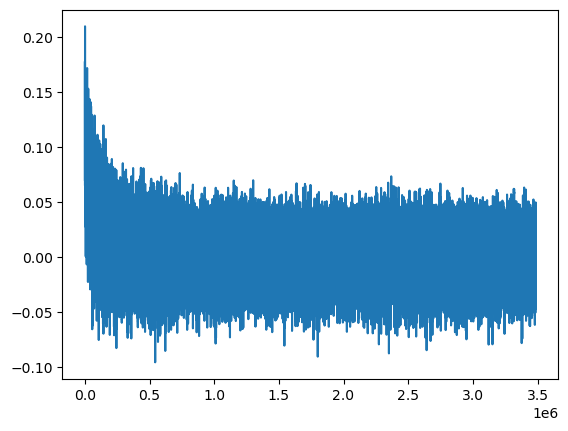

In [14]:
plt.plot(moving_avg)